In [1]:
import json
import cv2
import os
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dl.utils.io_utils import normalize_image

%matplotlib inline
from dl.utils.config import DEFAULT_TONEMAP_PARAMS

In [2]:
cvml_path = '/home/alex.li/git/JupiterCVML/europa/base/src/europa'
dataset_idx = 0
directory = ['/data/jupiter/datasets/bad_iq_halo_labelbox_plus_exposure', '/data2/jupiter/datasets/20231017_halo_rgb_labeled_excluded_bad_iq', '/data/jupiter/datasets/iq_2023_v5_anno'][dataset_idx]
csv_name = ['654a5bb2e89875bddc714dd2_master_annotations.csv', '653a7a0a3c2d8ab221f6d915_master_annotations.csv','64dfcc1de5a41169c7deb205_master_annotations.csv'][dataset_idx]

dset_name = directory.split('/')[-1]
save_path='/mnt/sandbox1/alex.li/iq_results'

side_left_tire_mask = f'{cvml_path}/cv/core/tire_masks/side_left_iq_mask.png'
side_right_tire_mask = f'{cvml_path}/cv/core/tire_masks/side_right_iq_mask.png'
stereo_df_full = pd.read_csv(os.path.join(directory, csv_name), low_memory=False)
example_ids = ['64e6934deef031aa465115f3']
stereo_df = stereo_df_full.drop_duplicates(['id'])
stereo_df = stereo_df[stereo_df['id'].isin(example_ids)]
print(len(stereo_df))

1


In [3]:
def load_object(row):
    folder_path  = directory + "/processed/images/" + row['id'] + "/"
    file_name = os.listdir(folder_path)[0]
    return np.load(folder_path + file_name)

def show_images(df):
    assert len(df) < 100, "Bro, too many images"
    n, m = len(df), 3
    fig, ax = plt.subplots(n, m, figsize=(m * 3.2, n * 4), squeeze=False)
    for i, (_, row) in enumerate(df.iterrows()):
        obj = load_object(row)
        im_l = normalize_image(obj['left'], row['hdr_mode'])
        im_r = normalize_image(obj['right'], row['hdr_mode'])
        im_depth = obj['point_cloud'][..., 2] / 100
        ax[i][0].set_title(row['id'])
        ax[i][1].set_title('right')
        ax[i][2].set_title('depth')
        ax[i][0].imshow(im_l)
        ax[i][1].imshow(im_r)
        ax[i][2].imshow(im_depth)

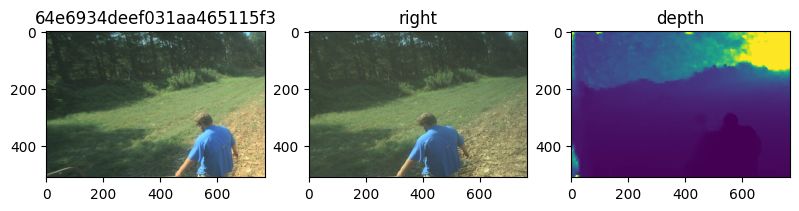

In [4]:
show_images(stereo_df)

In [5]:
obj = load_object(stereo_df.iloc[0])

In [6]:
obj['point_cloud'].shape
xs, ys, zs = obj['point_cloud'][:,:,0],obj['point_cloud'][:,:,1],obj['point_cloud'][:,:,2]

In [8]:
import pyvista
pyvista.set_jupyter_backend('server')
pyvista.start_xvfb()

which: no Xvfb in (/home/alex.li/miniconda3/envs/cvml/bin:/home/alex.li/.vscode-server/bin/1a5daa3a0231a0fbba4f14db7ec463cf99d7768e/bin/remote-cli:/tools/aws-cli/v2/bin:/home/alex.li/miniconda3/envs/cvml/bin:/home/alex.li/miniconda3/condabin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/alex.li/.local/bin:/home/alex.li/bin:/home/alex.li/.local/bin:/home/alex.li/bin)


OSError: Please install Xvfb with:

Debian
$ sudo apt install libgl1-mesa-glx xvfb

CentOS / RHL
$ sudo yum install libgl1-mesa-glx xvfb



In [ ]:
grid = pyvista.ImageData(dimensions=(3, 3, 1))
ugrid = grid.cast_to_unstructured_grid()

In [ ]:
pl = pyvista.Plotter()
pl.add_mesh(ugrid, show_edges=True)
pl.show()

/home/alex.li/miniconda3/envs/cvml/lib/python3.8/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(
ERROR:root:bad X server connection. DISPLAY=
2023-11-14 08:59:18.323 (   4.197s) [    7FEE2A8CF740]vtkXOpenGLRenderWindow.:456    ERR| vtkXOpenGLRenderWindow (0x55716eec8f90): bad X server connection. DISPLAY=


: 

In [51]:
np.stack([xs, ys, zs], axis=2).shape

(512, 768, 3)

In [ ]:
mesh = pv.PolyData((xs,ys,zs))
mesh.plot(point_size=10, style='points')

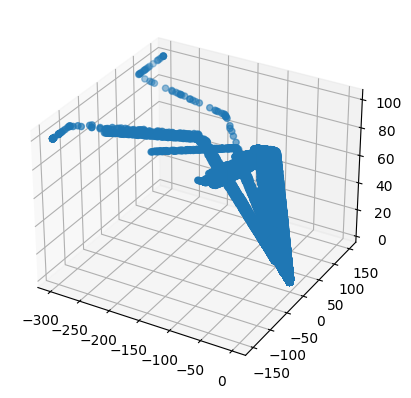

In [34]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs,ys,zs)